In [17]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import random
from math import pi
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay

# ----------------------------
# 1) Dataset
# ----------------------------
class GraphVoxelDataset(Dataset):
    def __init__(self, root_dir, split='train', grid_size=32, max_points=300, augment=True):
        """
        Args:
            root_dir (str): Path to DeepAirSig_Dataset folder
            split (str): 'train', 'val', or 'test'
            grid_size (int): voxel grid resolution
            max_points (int): number of points to pad/truncate to
            augment (bool): apply augmentation on train only
        """
        assert split in ('train', 'val', 'test')
        self.root_dir = root_dir
        self.split = split
        self.grid_size = grid_size
        self.max_points = max_points
        self.augment = augment

        self.samples = []  # list of (filepath, label)

        # 1a) genuine: train/val from Genuine/<subject>/train or test
        genuine_root = os.path.join(root_dir, 'Genuine')
        for subj in sorted(os.listdir(genuine_root)):
            subj_dir = os.path.join(genuine_root, subj)
            if not os.path.isdir(subj_dir):
                continue
            if split in ('train', 'val'):
                subfolder = 'train' if split == 'train' else 'test'
                folder = os.path.join(subj_dir, subfolder)
                if os.path.isdir(folder):
                    for fn in os.listdir(folder):
                        if fn.endswith('.txt'):
                            self.samples.append((os.path.join(folder, fn), 1))
            else:  # test
                # include genuine/test
                folder = os.path.join(subj_dir, 'test')
                if os.path.isdir(folder):
                    for fn in os.listdir(folder):
                        if fn.endswith('.txt'):
                            self.samples.append((os.path.join(folder, fn), 1))

        # 1b) forgery: only in test split, from Forgery/<subject>/*.txt
        if split == 'test':
            forgery_root = os.path.join(root_dir, 'Forged')
            for subj in sorted(os.listdir(forgery_root)):
                subj_dir = os.path.join(forgery_root, subj)
                if not os.path.isdir(subj_dir):
                    continue
                for fn in os.listdir(subj_dir):
                    if fn.endswith('.txt'):
                        self.samples.append((os.path.join(subj_dir, fn), 0))

        # shuffle so that subjects are mixed
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def _parse_file(self, path):
        pts = []
        with open(path, 'r') as f:
            for line in f:
                parts = re.split(r"[,\t ]+", line.strip())
                if len(parts) < 3:
                    continue
                try:
                    x, y, z = map(float, parts[:3])
                    pts.append([x, y, z])
                except:
                    continue
        return np.array(pts, dtype=np.float32)

    def _voxelize(self, pts):
        vox = np.zeros((self.grid_size,)*3, dtype=np.float32)
        if pts.size > 0:
            mn, mx = pts.min(0), pts.max(0)
            norm = (pts - mn) / (mx - mn + 1e-8)
            idx = (norm * (self.grid_size - 1)).astype(int)
            for x, y, z in idx:
                vox[x, y, z] += 1
            vox = np.log1p(vox)
        return vox

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            # 1) Parse file
            pts = self._parse_file(path)
    
            # 2) Pad or truncate to max_points
            if pts.shape[0] < self.max_points:
                pad = np.zeros((self.max_points - pts.shape[0], 3), dtype=np.float32)
                pts2 = np.vstack([pts, pad])
            else:
                pts2 = pts[:self.max_points]
    
            # 3) Augment (train split only)
            if self.augment and self.split == 'train':
                theta = random.uniform(-pi, pi)
                R = np.array([
                    [np.cos(theta), -np.sin(theta), 0],
                    [np.sin(theta),  np.cos(theta), 0],
                    [0,              0,             1]
                ], dtype=np.float32)
                pts2 = pts2 @ R.T
                if random.random() < 0.5:
                    pts2 += np.random.randn(*pts2.shape).astype(np.float32) * 0.02
    
            # 4) Graph branch tensor
            pts_tensor = torch.from_numpy(pts2).float()
    
            # 5) Voxel branch tensor (use original pts for voxelization)
            vox = self._voxelize(pts)
            vox_tensor = torch.from_numpy(vox).unsqueeze(0).float()
    
            return pts_tensor, vox_tensor, torch.tensor(label, dtype=torch.float32)
    
        except Exception as e:
            print(f"\n❗ Error loading sample idx={idx}, path={path}")
            print("Exception:", e)
            raise


# ----------------------------
# 2) Model
# ----------------------------
class GraphVoxelHybrid(nn.Module):
    def __init__(self, d_model=128, k=32):
        super().__init__()
        # point embedding + GCN
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.k = k
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                nn.ReLU(),
                nn.Dropout(0.2)
            ) for _ in range(3)
        ])
        # voxel branch
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4,4,4))
        )
        # cross-attention
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        # binary classifier
        self.cls = nn.Sequential(
            nn.Linear(d_model*4, d_model*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model*2, 1)  # single logit
        )

    def forward(self, pts, vox):
        B, P, _ = pts.size()
        x = self.pt_embed(pts)  # (B, P, d_model)

        # build adjacency via k-NN (no grad)
        with torch.no_grad():
            dist = torch.cdist(pts, pts)
            knn = dist.topk(self.k+1, largest=False).indices[:,:,1:]
            A = torch.zeros(B, P, P, device=pts.device)
            for b in range(B):
                A[b].scatter_(1, knn[b], 1)
            D = A.sum(-1).clamp_min(1)

        # GCN layers
        for layer in self.gcn_layers:
            x = (A @ x) / D.unsqueeze(-1)
            x = layer(x)

        # voxel features
        v = self.vx_proj(vox)  # (B, d_model, 4,4,4)
        v = rearrange(v, 'b c d h w -> b (d h w) c')  # (B, 64, d_model)

        # cross-attention
        p2v, _ = self.attn_p2v(v, x, x)
        v2p, _ = self.attn_v2p(x, v, v)

        # pooling
        p2v_pool = torch.cat([p2v.mean(1), p2v.max(1).values], dim=1)
        v2p_pool = torch.cat([v2p.mean(1), v2p.max(1).values], dim=1)

        feat = torch.cat([p2v_pool, v2p_pool], dim=1)  # (B, d_model*4)
        return self.cls(feat).squeeze(1)  # (B,)

# ----------------------------
# 3) Training + Evaluation
# ----------------------------
if __name__ == '__main__':
    # paths & hyperparams
    ROOT = r"C:\Users\thiru\Downloads\DeepAirSig_Dataset\DeepAirSig_Dataset"
    BATCH_SIZE = 32
    EPOCHS = 200
    PATIENCE = 10
    LR = 3e-4

    # data loaders
    train_ds = GraphVoxelDataset(ROOT, split='train', augment=True)
    val_ds   = GraphVoxelDataset(ROOT, split='val',   augment=False)
    test_ds  = GraphVoxelDataset(ROOT, split='test',  augment=False)

    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,   BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds,  BATCH_SIZE, shuffle=False, num_workers=0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphVoxelHybrid().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, EPOCHS+1):
        # -- train --
        model.train()
        t_loss = t_correct = t_total = 0
        for pts, vox, labels in train_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pts, vox)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            preds = (torch.sigmoid(outputs) >= 0.5).float()
            t_correct += (preds == labels).sum().item()
            t_total += labels.size(0)
            t_loss += loss.item() * labels.size(0)

        train_loss = t_loss / t_total
        train_acc  = 100. * t_correct / t_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # -- validate --
        model.eval()
        v_loss = v_correct = v_total = 0
        with torch.no_grad():
            for pts, vox, labels in val_loader:
                pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
                outputs = model(pts, vox)
                loss = criterion(outputs, labels)

                preds = (torch.sigmoid(outputs) >= 0.5).float()
                v_correct += (preds == labels).sum().item()
                v_total += labels.size(0)
                v_loss += loss.item() * labels.size(0)

        val_loss = v_loss / v_total
        val_acc  = 100. * v_correct / v_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        print(f"Epoch {epoch:03d} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_auth_model-2.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"\n⏹️ No improvement in {PATIENCE} epochs. Early stopping.")
                break

    # -- plot train/val curves --
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Over Epochs'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs,   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Over Epochs'); plt.legend()
    plt.tight_layout(); plt.show()

    # -- test authentication --
    model.load_state_dict(torch.load('best_auth_model-2.pt'))
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for pts, vox, labels in test_loader:
            pts, vox, labels = pts.to(device), vox.to(device), labels.to(device)
            outputs = model(pts, vox)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
            all_probs.extend(probs.cpu().numpy().tolist())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)
    all_probs  = np.array(all_probs)

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Forged','Genuine'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title("Authentication Confusion Matrix")
    plt.tight_layout(); plt.show()

    # classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['Forged','Genuine']))

    # ROC & AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout(); plt.show()


Epoch 001 | Train Loss: 0.3415 | Train Acc: 92.25% | Val Loss: 0.0922 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 002 | Train Loss: 0.0072 | Train Acc: 100.00% | Val Loss: 0.0035 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 003 | Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.0007 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 004 | Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.0003 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 005 | Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.0001 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 006 | Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.0000 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 007 | Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.0000 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 008 | Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.0000 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 009 | Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.0000 | Val Acc: 100.00% | LR: 3.00e-04
Epoch 010 | Train Loss: 0.0000 | Train Acc: 100.00% | Va

KeyboardInterrupt: 

Epoch 1/100
  Train Loss: 0.6521
  Val EER: 0.5500 @ threshold 0.38
Epoch 2/100
  Train Loss: 0.6436
  Val EER: 0.3500 @ threshold 0.39
Epoch 3/100
  Train Loss: 0.6385
  Val EER: 0.4000 @ threshold 0.42
Epoch 4/100
  Train Loss: 0.6298
  Val EER: 0.3500 @ threshold 0.33
Epoch 5/100
  Train Loss: 0.6261
  Val EER: 0.3000 @ threshold 0.32
Epoch 6/100
  Train Loss: 0.6307
  Val EER: 0.4000 @ threshold 0.23
Epoch 7/100
  Train Loss: 0.6360
  Val EER: 0.2500 @ threshold 0.36
Epoch 8/100
  Train Loss: 0.6205
  Val EER: 0.3000 @ threshold 0.60
Epoch 9/100
  Train Loss: 0.6362
  Val EER: 0.3500 @ threshold 0.31
Epoch 10/100
  Train Loss: 0.6102
  Val EER: 0.3500 @ threshold 0.35
Epoch 11/100
  Train Loss: 0.6327
  Val EER: 0.4000 @ threshold 0.26
Epoch 12/100
  Train Loss: 0.6265
  Val EER: 0.2500 @ threshold 0.43
Epoch 13/100
  Train Loss: 0.6164
  Val EER: 0.3000 @ threshold 0.31
Epoch 14/100
  Train Loss: 0.6093
  Val EER: 0.3000 @ threshold 0.31
Epoch 15/100
  Train Loss: 0.6057
  Val EER

C:\Users\thiru\AppData\Local\Temp\ipykernel_2224\1690644741.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



🔥 Final Test Performance 🔥
EER: 0.3500
              precision    recall  f1-score   support

      Forged       0.48      0.65      0.55        40
     Genuine       0.79      0.65      0.71        80

    accuracy                           0.65       120
   macro avg       0.63      0.65      0.63       120
weighted avg       0.69      0.65      0.66       120



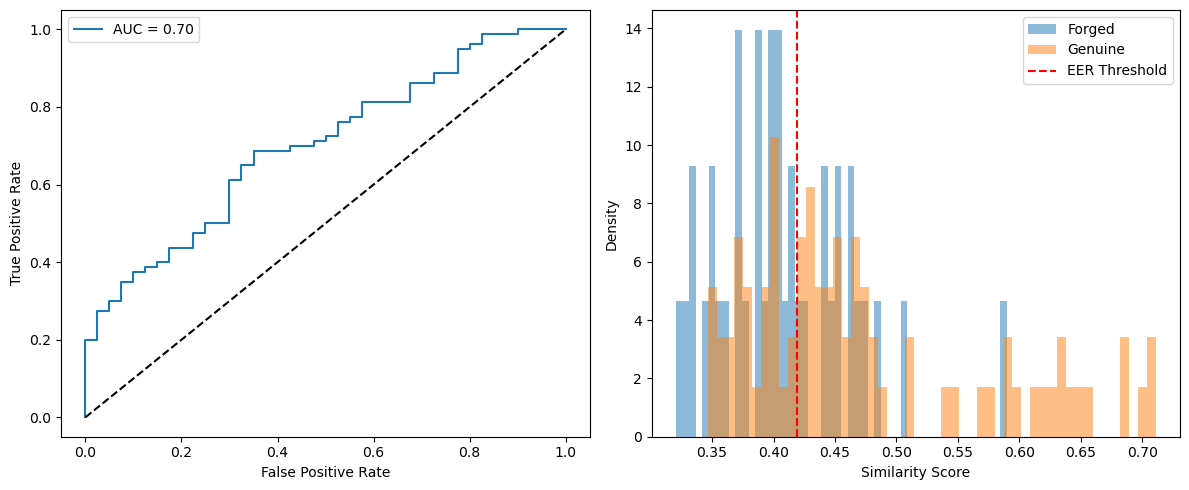

In [112]:
import os
import re
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from einops import rearrange

# ----------------------------
# 1. Hybrid Dataset Class
# ----------------------------
class HybridAuthDataset(Dataset):
    def __init__(self, root_dir, subjects, split='train', 
                 max_points=350, grid_size=32, augment=True):
        self.root_dir = root_dir
        self.subjects = subjects
        self.split = split
        self.max_points = max_points
        self.grid_size = grid_size
        self.augment = augment
        self.samples = []

        # Load data
        self._load_samples()

    def _load_samples(self):
        """Load samples with 1-digit subject IDs"""
        for subj in self.subjects:
            # Genuine samples
            genuine_path = os.path.join(self.root_dir, 'Genuine', f'subject_{subj}', self.split)
            if os.path.exists(genuine_path):
                for fn in os.listdir(genuine_path):
                    if fn.endswith('.txt'):
                        self.samples.append({
                            'path': os.path.join(genuine_path, fn),
                            'user': subj,
                            'label': 1
                        })
            
            # Forgery samples
            forged_path = os.path.join(self.root_dir, 'Forged', f'subject_{subj}')
            if os.path.exists(forged_path):
                all_files = [f for f in os.listdir(forged_path) if f.endswith('.txt')]
                train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42) \
                    if len(all_files) > 1 else (all_files, [])
                
                selected_files = train_files if self.split == 'train' else test_files
                for fn in (selected_files if selected_files else all_files):
                    self.samples.append({
                        'path': os.path.join(forged_path, fn),
                        'user': subj,
                        'label': 0
                    })

    def _parse_signature(self, path):
        """Load and normalize points"""
        pts = []
        with open(path, 'r') as f:
            for line in f:
                numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", line)
                if len(numbers) >= 3:
                    pts.append(list(map(float, numbers[:3])))
        pts = np.array(pts, dtype=np.float32)
        
        # Normalize to [0,1]
        if len(pts) > 0:
            pts_min = pts.min(0)
            pts_max = pts.max(0)
            pts_range = pts_max - pts_min
            pts_range[pts_range == 0] = 1  # Handle identical points
            pts = (pts - pts_min) / pts_range
            pts = np.clip(pts, 0.0, 1.0)
        
        # Pad/truncate
        if len(pts) < self.max_points:
            pts = np.pad(pts, [(0, self.max_points-len(pts)), (0,0)], mode='constant')
        else:
            pts = pts[:self.max_points]
        return pts

    def _voxelize(self, pts):
        """Convert points to voxel grid"""
        vox = np.zeros((self.grid_size,)*3, dtype=np.float32)
        if len(pts) > 0:
            indices = (pts * (self.grid_size - 1 - 1e-8))  # Prevent edge overflow
            indices = np.floor(indices).astype(int)
            indices = np.clip(indices, 0, self.grid_size-1)
            unique_indices, counts = np.unique(indices, axis=0, return_counts=True)
            for idx, count in zip(unique_indices, counts):
                vox[tuple(idx)] += count
                
        return np.log1p(vox + 1e-8)  # Avoid log(0)

    def _augment(self, pts):
        """Apply spatial augmentations"""
        if self.augment:
            # Random rotation
            theta = np.random.uniform(-np.pi, np.pi)
            R = np.array([
                [np.cos(theta), -np.sin(theta), 0],
                [np.sin(theta), np.cos(theta), 0],
                [0, 0, 1]
            ])
            pts = pts @ R.T
            
            # Random noise
            if random.random() < 0.5:
                pts += np.random.normal(0, 0.02, pts.shape)
        return pts

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        pts = self._parse_signature(sample['path'])
        pts = self._augment(pts)
        vox = self._voxelize(pts)
        return {
            'points': torch.FloatTensor(pts),
            'voxels': torch.FloatTensor(vox).unsqueeze(0),  # Add channel dim
            'label': sample['label'],
            'user': sample['user']
        }

# ----------------------------
# 2. Hybrid Model Architecture
# ----------------------------
class HybridAuthModel(nn.Module):
    def __init__(self, d_model=512, grid_size=32, num_heads=8):
        super().__init__()
        # point embedding + GCN
        self.pt_embed = nn.Sequential(
            nn.Linear(3, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.gcn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.LayerNorm(d_model),
                nn.ReLU(),
                nn.Dropout(0.2)
            ) for _ in range(3)
        ])
        # voxel branch
        self.vx_proj = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(64, d_model, 3, padding=1),
            nn.BatchNorm3d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4,4,4))
        )
        # cross-attention
        self.attn_p2v = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.attn_v2p = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        # binary classifier
        self.cls = nn.Sequential(
            nn.Linear(d_model*4, d_model*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model*2, 1)  # single logit
        )

    def forward(self, points, voxels):
        B = points.size(0)
        
        # Process points
        x_pts = self.pt_embed(points)  # (B, 300, d_model)
        for layer in self.gcn_layers:
            x_pts = layer(x_pts)
        
        # Process voxels
        x_vox = self.vx_proj(voxels)  # (B, d_model, 4,4,4)
        x_vox = rearrange(x_vox, 'b c d h w -> b (d h w) c')  # (B, 64, d_model)
        
        # Cross attention
        p2v_out, _ = self.attn_p2v(x_vox, x_pts, x_pts)  # (B, 64, d_model)
        v2p_out, _ = self.attn_v2p(x_pts, x_vox, x_vox)  # (B, 300, d_model)
        
        # Pool features
        p2v_mean = p2v_out.mean(1)
        p2v_max = p2v_out.max(1).values
        v2p_mean = v2p_out.mean(1)
        v2p_max = v2p_out.max(1).values
        
        combined = torch.cat([p2v_mean, p2v_max, v2p_mean, v2p_max], dim=1)
        return self.cls(combined).squeeze(1)

# ----------------------------
# 3. Training Utilities
# ----------------------------
def hybrid_collate(batch):
    return {
        'points': torch.stack([x['points'] for x in batch]),
        'voxels': torch.stack([x['voxels'] for x in batch]),
        'label': torch.tensor([x['label'] for x in batch]),
        'user': torch.tensor([x['user'] for x in batch])
    }

def calculate_eer(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fpr - fnr))
    return fpr[eer_idx], thresholds[eer_idx]

def evaluate(model, loader, device):
    model.eval()
    scores, labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'user'}
            outputs = model(inputs['points'], inputs['voxels'])
            scores.extend(torch.sigmoid(outputs).cpu().numpy())
            labels.extend(batch['label'].cpu().numpy())
    return np.array(scores), np.array(labels)

def plot_metrics(labels, scores, threshold):
    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # Score Distribution
    plt.subplot(1,2,2)
    plt.hist(scores[labels==0], bins=50, alpha=0.5, label='Forged', density=True)
    plt.hist(scores[labels==1], bins=50, alpha=0.5, label='Genuine', density=True)
    plt.axvline(threshold, color='r', linestyle='--', label='EER Threshold')
    plt.xlabel('Similarity Score')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------
# 4. Training Pipeline
# ----------------------------
def main():
    # Configuration
    ROOT = r"C:\Users\thiru\Downloads\DeepAirSig_Dataset\DeepAirSig_Dataset"
    SUBJECTS = list(range(1, 41))  # Subjects 1-40
    BATCH_SIZE = 32
    EPOCHS = 100
    LR = 3e-4
    
    # Split subjects
    train_subjs, test_subjs = train_test_split(SUBJECTS, test_size=0.2, random_state=42)
    train_subjs, val_subjs = train_test_split(train_subjs, test_size=0.1, random_state=42)
    
    # Datasets
    train_ds = HybridAuthDataset(ROOT, train_subjs, 'train')
    val_ds = HybridAuthDataset(ROOT, val_subjs, 'test')
    test_ds = HybridAuthDataset(ROOT, test_subjs, 'test')
    
    # DataLoaders
    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, collate_fn=hybrid_collate)
    val_loader = DataLoader(val_ds, BATCH_SIZE, collate_fn=hybrid_collate)
    test_loader = DataLoader(test_ds, BATCH_SIZE, collate_fn=hybrid_collate)
    
    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HybridAuthModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()
    
    best_eer = float('inf')
    for epoch in range(EPOCHS):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            points = batch['points'].to(device)
            voxels = batch['voxels'].to(device)
            labels = batch['label'].float().to(device)
            
            outputs = model(points, voxels)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        val_scores, val_labels = evaluate(model, val_loader, device)
        eer, threshold = calculate_eer(val_labels, val_scores)
        
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"  Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"  Val EER: {eer:.4f} @ threshold {threshold:.2f}")
        
        # Save best model
        if eer < best_eer:
            best_eer = eer
            torch.save(model.state_dict(), 'best_model.pth')
    
    # Final Evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    test_scores, test_labels = evaluate(model, test_loader, device)
    eer, threshold = calculate_eer(test_labels, test_scores)
    
    print("\n🔥 Final Test Performance 🔥")
    print(f"EER: {eer:.4f}")
    print(classification_report(test_labels, test_scores >= threshold, 
                               target_names=['Forged', 'Genuine']))
    plot_metrics(test_labels, test_scores, threshold)

if __name__ == '__main__':
    main()

In [110]:
import os
import re
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from einops import rearrange
import matplotlib.pyplot as plt

# ----------------------------
# 1. Hybrid Dataset Class with Full Caching
# ----------------------------
class HybridAuthDataset(Dataset):
    def __init__(self, root_dir, subjects, split='train', 
                 max_points=300, grid_size=32, augment=True):
        self.root_dir = root_dir
        self.samples = []
        self.max_points = max_points
        self.grid_size = grid_size
        self.augment = augment
        # load sample paths
        for subj in subjects:
            gdir = os.path.join(root_dir, 'Genuine', f'subject_{subj}', split)
            if os.path.isdir(gdir):
                for fn in os.listdir(gdir):
                    if fn.endswith('.txt'):
                        self.samples.append((os.path.join(gdir, fn), 1))
            fdir = os.path.join(root_dir, 'Forged', f'subject_{subj}')
            if os.path.isdir(fdir):
                files = [f for f in os.listdir(fdir) if f.endswith('.txt')]
                train_f, test_f = train_test_split(files, test_size=0.2, random_state=42) if len(files)>1 else (files, [])
                sel = train_f if split=='train' else test_f
                for fn in (sel or files):
                    self.samples.append((os.path.join(fdir, fn), 0))
        # preload and cache tensors
        self.points_cache = []
        self.vox_cache = []
        self.labels_cache = []
        for path, lbl in self.samples:
            pts = self._parse(path)
            self.points_cache.append(torch.tensor(pts, dtype=torch.float32))
            vox = self._voxelize(pts)
            self.vox_cache.append(torch.tensor(vox, dtype=torch.float32).unsqueeze(0))
            self.labels_cache.append(torch.tensor(lbl, dtype=torch.float32))
    
    def _parse(self, path):
        pts = []
        with open(path) as f:
            for L in f:
                nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", L)
                if len(nums)>=3:
                    pts.append(list(map(float, nums[:3])))
        pts = np.array(pts, np.float32)
        if pts.size:
            mn, mx = pts.min(0), pts.max(0)
            rng = np.where(mx-mn==0, 1, mx-mn)
            pts = (pts-mn)/rng
        if len(pts)<self.max_points:
            pts = np.pad(pts, [(0,self.max_points-len(pts)),(0,0)], 'constant')
        else:
            pts = pts[:self.max_points]
        return pts

    def _voxelize(self, pts):
        idx = np.floor(pts*(self.grid_size-1-1e-8)).astype(int)
        idx = np.clip(idx,0,self.grid_size-1)
        flat = idx[:,0]*self.grid_size**2 + idx[:,1]*self.grid_size + idx[:,2]
        cnt = np.bincount(flat, minlength=self.grid_size**3).reshape(self.grid_size, self.grid_size, self.grid_size)
        return np.log1p(cnt.astype(np.float32))

    def __len__(self):
        return len(self.points_cache)

    def __getitem__(self, i):
        pts = self.points_cache[i]
        if self.augment:
            theta = torch.rand(1).item()*2*np.pi - np.pi
            R = torch.tensor(
                [[np.cos(theta), -np.sin(theta), 0],
                 [np.sin(theta),  np.cos(theta), 0],
                 [0,               0,            1]],
                dtype=torch.float32
            )
            pts = pts @ R.T
            if random.random() < 0.5:
                pts += torch.randn_like(pts) * 0.02
        return pts, self.vox_cache[i], self.labels_cache[i]

# ----------------------------
# 2. Static EdgeConv & Res3D
# ----------------------------
class EdgeConv(nn.Module):
    def __init__(self, channels, k=8, num_points=300):
        super().__init__()
        self.k = k
        neigh = []
        for i in range(num_points):
            low = max(0, i-k//2)
            high = min(num_points, i+k//2+1)
            nb = [j for j in range(low,high) if j!=i]
            nb += [i] * (k - len(nb))
            neigh.append(nb[:k])
        self.register_buffer('nbr_idx', torch.LongTensor(neigh))
        self.mlp = nn.Sequential(
            nn.Linear(2*channels, channels),
            nn.ReLU(),
            nn.Linear(channels, channels)
        )

    def forward(self, x):
        B,N,C = x.shape
        x_i = x.unsqueeze(2)
        x_j = x[:, self.nbr_idx, :]
        h = torch.cat([x_i.expand(-1,-1,self.k,-1), x_j - x_i.expand(-1,-1,self.k,-1)], dim=-1)
        return self.mlp(h).max(dim=2).values

class ResBlock3D(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(c,c,3,padding=1),
            nn.BatchNorm3d(c),
            nn.ReLU(),
            nn.Conv3d(c,c,3,padding=1),
            nn.BatchNorm3d(c)
        )
    def forward(self, x):
        return F.relu(self.block(x) + x)

# ----------------------------
# 3. HybridAuthModel
# ----------------------------
class HybridAuthModel(nn.Module):
    def __init__(self, d=128, num_points=300, grid_size=32, heads=4):
        super().__init__()
        self.embed_pt = nn.Linear(3, d)
        self.econvs = nn.ModuleList([EdgeConv(d, k=8, num_points=num_points) for _ in range(2)])
        self.conv3d = nn.Sequential(
            nn.Conv3d(1, d, 3, padding=1),
            nn.ReLU(),
            ResBlock3D(d),
            nn.AdaptiveAvgPool3d((4,4,4))
        )
        self.attn = nn.MultiheadAttention(d, heads, batch_first=True)
        self.fc = nn.Linear(d, 1)

    def forward(self, pts, vox):
        x = F.relu(self.embed_pt(pts))
        for ec in self.econvs:
            x = ec(x)
        x = x.mean(1).unsqueeze(1)
        v = self.conv3d(vox)
        v = rearrange(v, 'b c d h w -> b (d h w) c')
        v = v.mean(1).unsqueeze(1)
        y, _ = self.attn(x, v, v)
        return self.fc(y.squeeze(1)).squeeze(1)

# ----------------------------
# 4. Training Loop with Plots
# ----------------------------
def collate_fn(batch):
    pts, vox, lbls = zip(*batch)
    return torch.stack(pts), torch.stack(vox), torch.stack(lbls)

def compute_eer(labels, scores):
    fpr, tpr, thr = roc_curve(labels, scores)
    fnr = 1 - tpr
    idx = np.abs(fpr - fnr).argmin()
    return (fpr[idx] + fnr[idx]) / 2, thr[idx], fpr, tpr


def train_and_plot():
    ROOT = r"C:\Users\thiru\Downloads\DeepAirSig_Dataset\DeepAirSig_Dataset"
    subs = list(range(1, 41))
    tr, ts = train_test_split(subs, test_size=0.2, random_state=42)
    tr, val = train_test_split(tr, test_size=0.1, random_state=42)
    tr_ds = HybridAuthDataset(ROOT, tr, 'train')
    val_ds = HybridAuthDataset(ROOT, val, 'test')
    tr_dl = DataLoader(tr_ds, 32, shuffle=True, collate_fn=collate_fn)
    val_dl = DataLoader(val_ds, 32, collate_fn=collate_fn)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HybridAuthModel().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    bce = nn.BCEWithLogitsLoss()

    best_eer = 1.0
    for epoch in range(20):
        model.train()
        total_loss = 0
        for pts, vox, lbl in tr_dl:
            pts, vox, lbl = pts.to(device), vox.to(device), lbl.to(device)
            opt.zero_grad()
            logits = model(pts, vox)
            loss = bce(logits, lbl)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        model.eval()
        scores, labs = [], []
        with torch.no_grad():
            for pts, vox, lbl in val_dl:
                logits = model(pts.to(device), vox.to(device))
                scores.extend(torch.sigmoid(logits).cpu().numpy())
                labs.extend(lbl.numpy())
        labs = np.array(labs)
        scores = np.array(scores)
        eer, thr, fpr, tpr = compute_eer(labs, scores)
        print(f"Epoch {epoch}: Loss {total_loss/len(tr_dl):.4f}, Val EER {eer:.4f}")
        if eer < best_eer:
            best_eer = eer
            torch.save(model.state_dict(), 'best.pth')

    # Final plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(scores[labs == 0], bins=30, alpha=0.5, label='Forged', density=True)
    plt.hist(scores[labs == 1], bins=30, alpha=0.5, label='Genuine', density=True)
    plt.axvline(thr, color='k', linestyle='--', label='EER Threshold')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Score Distributions')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    train_and_plot()


KeyboardInterrupt: 

Epoch 0: Loss=0.6534, Val EER=0.2875
Epoch 1: Loss=0.6470, Val EER=0.2875
Epoch 2: Loss=0.6394, Val EER=0.1750
Epoch 3: Loss=0.6388, Val EER=0.1500
Epoch 4: Loss=0.6375, Val EER=0.1500
Epoch 5: Loss=0.6386, Val EER=0.1250
Epoch 6: Loss=0.6394, Val EER=0.1750
Epoch 7: Loss=0.6407, Val EER=0.2000
Epoch 8: Loss=0.6353, Val EER=0.2625
Epoch 9: Loss=0.6313, Val EER=0.2500
Epoch 10: Loss=0.6169, Val EER=0.2625
Epoch 11: Loss=0.6238, Val EER=0.3500
Epoch 12: Loss=0.6207, Val EER=0.3500
Epoch 13: Loss=0.6241, Val EER=0.4000
Epoch 14: Loss=0.6128, Val EER=0.3875
Epoch 15: Loss=0.6114, Val EER=0.3625
Epoch 16: Loss=0.6262, Val EER=0.3375
Epoch 17: Loss=0.6043, Val EER=0.3625
Epoch 18: Loss=0.5803, Val EER=0.4000
Epoch 19: Loss=0.5770, Val EER=0.4125
Epoch 20: Loss=0.5663, Val EER=0.3375
Epoch 21: Loss=0.5850, Val EER=0.4000
Epoch 22: Loss=0.5828, Val EER=0.3875
Epoch 23: Loss=0.5395, Val EER=0.3625
Epoch 24: Loss=0.5265, Val EER=0.3500
Epoch 25: Loss=0.5316, Val EER=0.3250
Epoch 26: Loss=0.4983,

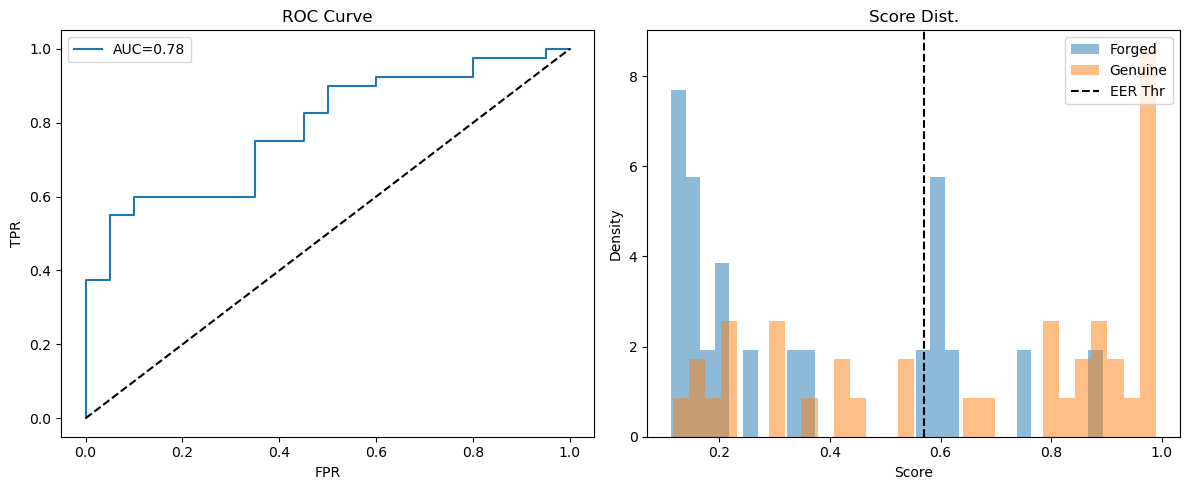

In [114]:
import os
import re
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from einops import rearrange
import matplotlib.pyplot as plt

# ----------------------------
# 1. Point-Cloud Dataset with Caching
# ----------------------------
class PointAuthDataset(Dataset):
    def __init__(self, root_dir, subjects, split='train', max_points=300, augment=True):
        self.samples = []
        self.max_points = max_points
        self.augment = augment
        # load paths
        for subj in subjects:
            gdir = os.path.join(root_dir, 'Genuine', f'subject_{subj}', split)
            if os.path.isdir(gdir):
                for fn in os.listdir(gdir):
                    if fn.endswith('.txt'):
                        self.samples.append((os.path.join(gdir, fn), 1))
            fdir = os.path.join(root_dir, 'Forged', f'subject_{subj}')
            if os.path.isdir(fdir):
                files = [f for f in os.listdir(fdir) if f.endswith('.txt')]
                train_f, test_f = train_test_split(files, test_size=0.2, random_state=42) if len(files)>1 else (files, [])
                sel = train_f if split=='train' else test_f
                for fn in (sel or files):
                    self.samples.append((os.path.join(fdir, fn), 0))
        # cache points & labels
        self.points_cache = []
        self.labels_cache = []
        for path, lbl in self.samples:
            pts = self._parse(path)
            self.points_cache.append(torch.tensor(pts, dtype=torch.float32))
            self.labels_cache.append(torch.tensor(lbl, dtype=torch.float32))

    def _parse(self, path):
        pts = []
        with open(path) as f:
            for line in f:
                nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", line)
                if len(nums) >= 3:
                    pts.append(list(map(float, nums[:3])))
        pts = np.array(pts, dtype=np.float32)
        if pts.size:
            mn, mx = pts.min(0), pts.max(0)
            rng = np.where(mx-mn==0, 1, mx-mn)
            pts = (pts - mn) / rng
        if len(pts) < self.max_points:
            pts = np.pad(pts, [(0, self.max_points-len(pts)), (0, 0)], 'constant')
        else:
            pts = pts[:self.max_points]
        return pts

    def __len__(self):
        return len(self.points_cache)

    def __getitem__(self, idx):
        pts = self.points_cache[idx].clone()
        if self.augment:
            theta = random.uniform(-np.pi, np.pi)
            R = torch.tensor([[np.cos(theta), -np.sin(theta), 0],
                              [np.sin(theta),  np.cos(theta), 0],
                              [0,               0,            1]], dtype=torch.float32)
            pts = pts @ R.T
            if random.random() < 0.5:
                pts += torch.randn_like(pts) * 0.02
        label = self.labels_cache[idx]
        return pts, label

# ----------------------------
# 2. Graph-Based Point Encoder
# ----------------------------
class EdgeConv(nn.Module):
    def __init__(self, channels, k=8, num_points=300):
        super().__init__()
        self.k = k
        neigh = []
        for i in range(num_points):
            low = max(0, i-k//2)
            high = min(num_points, i+k//2+1)
            nb = [j for j in range(low, high) if j != i]
            nb += [i] * (k - len(nb))
            neigh.append(nb[:k])
        self.register_buffer('nbr_idx', torch.LongTensor(neigh))
        self.mlp = nn.Sequential(
            nn.Linear(2*channels, channels),
            nn.ReLU(),
            nn.Linear(channels, channels)
        )

    def forward(self, x):
        x_i = x.unsqueeze(2)  # B x N x 1 x C
        x_j = x[:, self.nbr_idx, :]  # B x N x k x C
        h = torch.cat([x_i.expand(-1,-1,self.k,-1), x_j - x_i.expand(-1,-1,self.k,-1)], dim=-1)
        return self.mlp(h).max(dim=2).values  # B x N x C

class PointAuthModel(nn.Module):
    def __init__(self, d=128, num_points=300, k=8):
        super().__init__()
        self.embed = nn.Linear(3, d)
        self.econvs = nn.ModuleList([EdgeConv(d, k=k, num_points=num_points) for _ in range(3)])
        self.fc = nn.Sequential(
            nn.Linear(d, d//2),
            nn.ReLU(),
            nn.Linear(d//2, 1)
        )

    def forward(self, x):
        # x: B x N x 3
        x = F.relu(self.embed(x))  # B x N x d
        for ec in self.econvs:
            x = ec(x)
        x = x.mean(dim=1)         # global mean pooling -> B x d
        return self.fc(x).squeeze(1)

# ----------------------------
# 3. Training & Evaluation
# ----------------------------
def collate_fn(batch):
    pts, lbls = zip(*batch)
    return torch.stack(pts), torch.stack(lbls)


def compute_eer(labels, scores):
    fpr, tpr, thr = roc_curve(labels, scores)
    fnr = 1 - tpr
    idx = (np.abs(fpr - fnr)).argmin()
    return (fpr[idx] + fnr[idx]) / 2, thr[idx], fpr, tpr


def train_and_plot():
    ROOT = r"C:\Users\thiru\Downloads\DeepAirSig_Dataset\DeepAirSig_Dataset"
    subs = list(range(1, 41))
    tr, ts = train_test_split(subs, test_size=0.2, random_state=42)
    tr, val = train_test_split(tr, test_size=0.1, random_state=42)
    tr_ds = PointAuthDataset(ROOT, tr, 'train')
    val_ds = PointAuthDataset(ROOT, val, 'test', augment=False)
    tr_dl = DataLoader(tr_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_dl = DataLoader(val_ds, batch_size=32, collate_fn=collate_fn)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PointAuthModel().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_eer = 1.0
    for epoch in range(30):
        model.train()
        total_loss = 0
        for pts, lbl in tr_dl:
            pts, lbl = pts.to(device), lbl.to(device)
            opt.zero_grad()
            logits = model(pts)
            loss = criterion(logits, lbl)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        model.eval()
        scores, labs = [], []
        with torch.no_grad():
            for pts, lbl in val_dl:
                pts = pts.to(device)
                logits = model(pts)
                scores.extend(torch.sigmoid(logits).cpu().numpy())
                labs.extend(lbl.numpy())
        labs = np.array(labs)
        scores = np.array(scores)
        eer, thr, fpr, tpr = compute_eer(labs, scores)
        print(f"Epoch {epoch}: Loss={total_loss/len(tr_dl):.4f}, Val EER={eer:.4f}")
        if eer < best_eer:
            best_eer = eer
            torch.save(model.state_dict(), 'best_point_model.pth')

    # Plot ROC & distribution
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'AUC={auc(fpr,tpr):.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()

    plt.subplot(1,2,2)
    plt.hist(scores[labs==0], bins=30, alpha=0.5, label='Forged', density=True)
    plt.hist(scores[labs==1], bins=30, alpha=0.5, label='Genuine', density=True)
    plt.axvline(thr, color='k', linestyle='--', label='EER Thr')
    plt.xlabel('Score'); plt.ylabel('Density'); plt.title('Score Dist.'); plt.legend()

    plt.tight_layout(); plt.show()

if __name__ == '__main__':
    train_and_plot()
